# Preamble

In [1]:
import json
import pandas as pd
import numpy as np
import typing
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt
from functools import reduce

# Functions to process individual subjects and find subjects within directory

In [2]:
def process_subject(path: typing.Union[str, Path]):
    '''
    given a path to a jspsych experiment saved data, processes the subject to extract a 
    dataframe with only relevant information retaiend and properly organized
    '''
    with Path(path).open('r') as f:
        data = json.load(f)

    metadata = {}
    lowercased_dict_keys = lambda dikt: {k.lower(): v for k, v in dikt.items()}

    metadata['subject_id'] = data[0]['subject_id']
    metadata['study_id'] = data[0]['study_id']
    for i in (1, 2):
        metadata.update(lowercased_dict_keys(data[i]['response']))
    try:
        metadata['age'] = int(metadata['age'])
    except ValueError:
        metadata['age'] = float('nan')

    frames = []
    skipped = 0
    for i in range(len(data)):
        if data[i]['trial_type'] != 'survey-likert':
            skipped += 1
            continue
        frame = {}
        frame.update(metadata)

        for k in ('rt', 'time_elapsed', 'trial_index'):
            frame[k] = data[i][k]
        [frame['item']] = [*data[i]['response'].keys()]
        [frame['response']] = [*data[i]['response'].values()]
        frame['response'] += -3
        frame['trial_index'] += -skipped
        if frame['item'].startswith('gold_'):
            frame['item'] = frame['item'][len('gold_'):]
            frame['trial_type'] = 'gold'
        else:
            frame['trial_type'] = 'actual'


        frames += [frame]

    return pd.DataFrame(frames)

In [3]:
def find_subject(
    subject_id, basedir=Path("pilot1/").expanduser().resolve(), search_all=True
):
    processed = []
    for path in basedir.glob("*.json"):
        with Path(path).open("r") as f:
            data = json.load(f)
            if subject_id == data[0]["subject_id"]:
                processed += [process_subject(path)]
                if search_all:
                    continue
                else:
                    break
    if processed:
        return pd.concat(processed)
    raise FileNotFoundError(f"no response for subject `{subject_id}` at `{basedir}`")


# Playground

In [402]:
tmp = find_subject('5f4c042383588080d02e61a3')

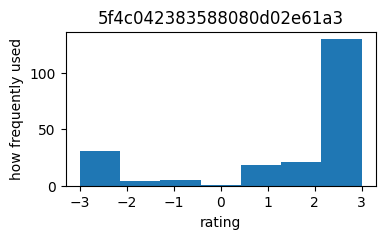

In [392]:
f, a = plt.subplots(figsize=(4,2))
a.hist(tmp.response, bins=7)
a.set(title=tmp.subject_id.iloc[0], xlabel='rating', ylabel='how frequently used')
plt.show()

In [8]:
basedir = Path('pilot1/').expanduser().resolve()
glob = [*basedir.glob('*.json')]
df = pd.concat(process_subject(sub) for sub in glob).reset_index(drop=True)

subject_to_ix = {} # dict((item, i) for i, item in enumerate(set(df.subject_id)))
# item_to_ix = dict((item, i) for i, item in enumerate(set(df.item)))
item_to_ix = {}
for i, row in df[[ 'item', 'trial_type', 'subject_id' ]].iterrows():
    item = row['item']
    tt = row['trial_type']
    sub = row['subject_id']
    item_to_ix[item] = len(item_to_ix)
    if sub not in subject_to_ix: subject_to_ix[sub] = len(subject_to_ix)

ix_to_item = {v:k for k, v in item_to_ix.items()}

df['item_index'] = df['item'].apply(lambda item: item_to_ix[item])

In [400]:
Counter(df.groupby('item').count().sort_values(by='item_index', ascending=False).item_index)

Counter({11: 10, 3: 1, 2: 97, 1: 2003})

In [349]:
df.groupby('subject_id').count()

,study_id,country,language,gender,age,rt,time_elapsed,trial_index,item,response,trial_type,item_index
subject_id,,,,,,,,,,,,
5964a95d1e40d0000196646c,210,210,210,210,210,210,210,210,210,210,210,210
5ea10b955d9b25000c302fc5,210,210,210,210,210,210,210,210,210,210,210,210
5f19dc86afa07c0894f60578,210,210,210,210,210,210,210,210,210,210,210,210
5f4c042383588080d02e61a3,210,210,210,210,210,210,210,210,210,210,210,210
5fa318d8cbda73497645e374,210,210,210,210,210,210,210,210,210,210,210,210
5fe932138929f08811367974,210,210,210,210,210,210,210,210,210,210,210,210
603af68f8d9a2b7881a2aebe,210,210,210,210,210,210,210,210,210,210,210,210
609075e9a3db190aabf0302c,210,210,210,210,210,210,210,210,210,210,210,210
60e4e2669d7efce16a1d7540,420,420,420,420,420,420,420,420,420,420,420,420


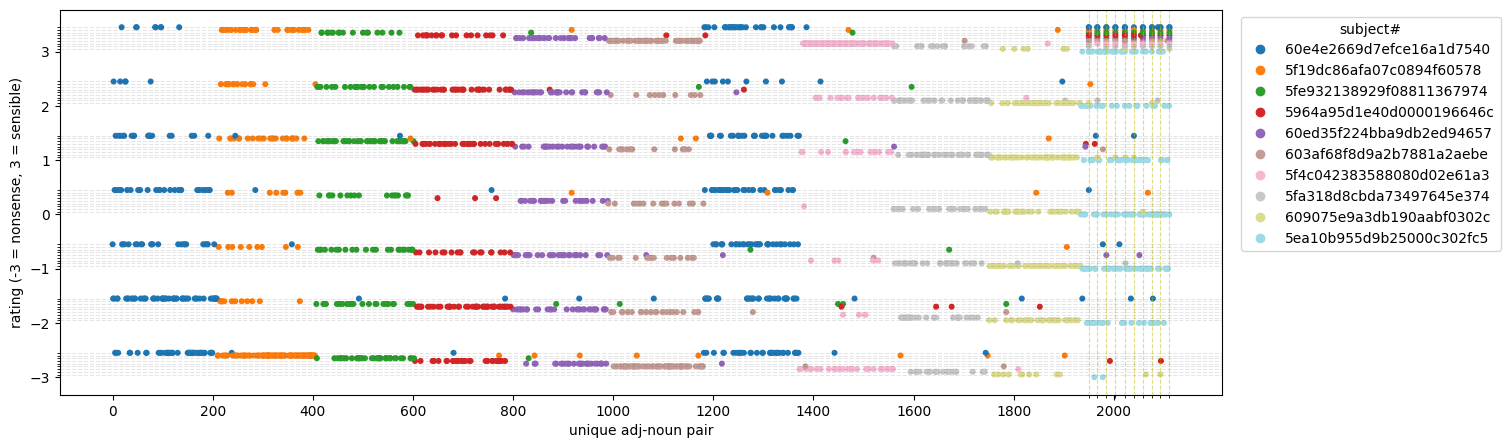

In [396]:
from matplotlib.colors import ListedColormap

view = df.sort_values(by='response')

f, a = plt.subplots(figsize=(15, 5))

col_ix = np.where(view["trial_type"] == "actual", 1, 0)
sub_ix = np.array([subject_to_ix[sub] for sub in view.subject_id])
cmap = ListedColormap(("r", "b"))

subject_wise_increment = 1 / len(subject_to_ix) / 2
scatter = a.scatter(
    view['item_index'],
    view["response"] + (len(subject_to_ix) - sub_ix - 1) * subject_wise_increment,
    c=sub_ix,
    s=11,
    alpha=1,
    cmap="tab20",
    # cmap="copper",
)

a.set_yticks(sorted(set(view["response"])))
min_rating = -3
max_rating = +3

a.set_xticks(
    np.arange(0, max(view.item_index), 200),
    minor=False,
)
a.set_xticks(
    sorted(
        {
            row['item_index']
            for i, row in view[["item_index", "trial_type"]].iterrows()
            if row["trial_type"] == "gold"
        }
    ),
    minor=True,
)
a.set_yticks(
    reduce(
        list.__add__,
        [
            list(np.arange(i, i + 0.5, subject_wise_increment))
            for i in range(min_rating, max_rating + 1)
        ],
    ),
    minor=True,
)

a.set(xlabel="unique adj-noun pair", ylabel="rating (-3 = nonsense, 3 = sensible)")

plt.legend(
    handles=scatter.legend_elements()[0],
    # labels=["gold", "actual"],
    # labels=[ix for ix in range(len(subject_to_ix))],
    labels=subject_to_ix,
    bbox_to_anchor=(1.01, 1),
    loc="upper left",
    title="subject#",
)
plt.grid(alpha=0.1, which="minor", axis="y", visible=True, color="k", linestyle="--")
# plt.grid(alpha=0.1, which="minor", axis="x", visible=True, color="y")
plt.grid(
    alpha=0.5,
    which="minor",
    axis="x",
    visible=True,
    color="y",
    linestyle='--',
)

plt.show()


[Text(0.5, 0, 'rating'), Text(0, 0.5, 'frequency')]

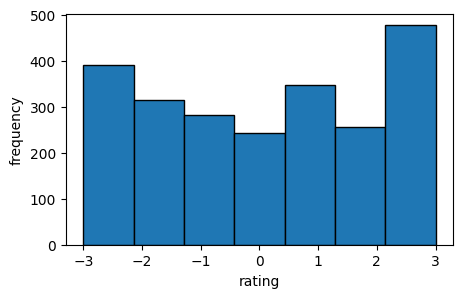

In [335]:
f,a = plt.subplots(figsize=(5,3))
a.hist(df['response'], bins=7, edgecolor='black')
a.set(xlabel='rating', ylabel='frequency')

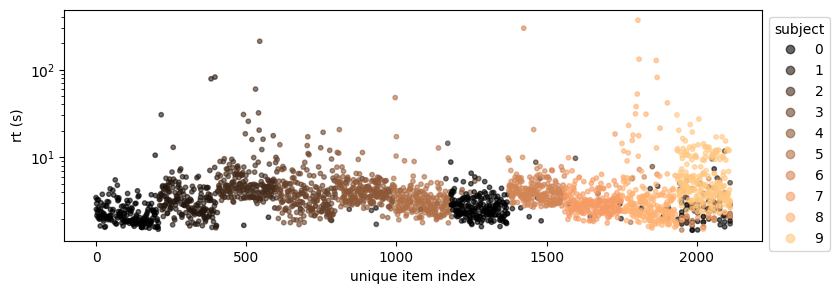

In [355]:
from matplotlib.colors import ListedColormap
inv = lambda dikt: {v:k for k,v in dikt.items()} 

f, a = plt.subplots(figsize=(9,3))

col_ix = np.where(df['trial_type'] == 'actual', 1, 0)
sub_ix = np.array([subject_to_ix[sub] for sub in df['subject_id']])

cmap = ListedColormap(('r', 'b'))
scatter = a.scatter(df['item_index'], df['rt']/10**3, c=sub_ix, s=10, alpha=.6, cmap='copper')

a.set(yscale='log', ylabel='rt (s)', xlabel='unique item index')

plt.legend(
    handles=scatter.legend_elements()[0],
    labels=[ix for ix in range(len(subject_to_ix))],
    bbox_to_anchor=(1., 1.),
    loc="upper left",
    title='subject',
)

plt.show()

In [15]:
df.groupby('subject_id').mean()

,age,rt,time_elapsed,trial_index,response,item_index
subject_id,,,,,,
5964a95d1e40d0000196646c,24.0,4089.542857,5.348160e+05,104.5,0.047619,820.919048
5ea10b955d9b25000c302fc5,31.0,6598.971429,8.269031e+05,104.5,0.395238,2021.638095
5f19dc86afa07c0894f60578,23.0,4186.071429,4.693718e+05,104.5,-0.476190,496.109524
5f4c042383588080d02e61a3,22.0,5763.671429,7.767940e+05,104.5,1.638095,1496.947619
5fa318d8cbda73497645e374,21.0,3209.257143,4.237151e+05,104.5,0.295238,1678.400000
5fe932138929f08811367974,22.0,6965.957143,1.050954e+06,104.5,-0.080952,626.700000
603af68f8d9a2b7881a2aebe,20.0,3548.761905,4.768774e+05,104.5,-0.019048,1154.023810
609075e9a3db190aabf0302c,22.0,7795.890476,1.007767e+06,104.5,0.061905,1853.609524
60e4e2669d7efce16a1d7540,25.0,2589.683333,3.137751e+05,104.5,-0.533333,816.400000


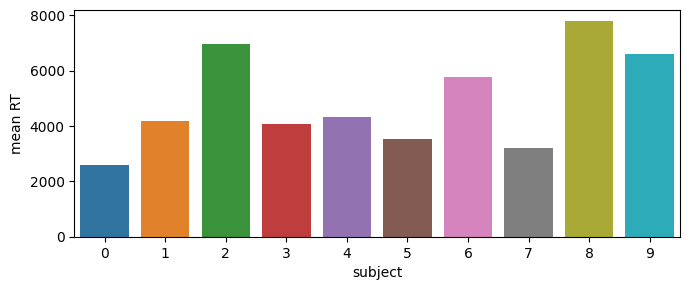

In [5]:
import seaborn as sns
f,a = plt.subplots(figsize=(7,3))
view = df.groupby('subject_id').mean().reset_index()
view['subject_ix'] = view['subject_id'].apply(lambda sub_id: subject_to_ix[sub_id])
bar = sns.barplot(data=view, x='subject_ix', y='rt')
# f.set_xticks(range(11))
# plt.xticks(rotation=70)
a.set(xlabel='subject', ylabel='mean RT')
plt.tight_layout()

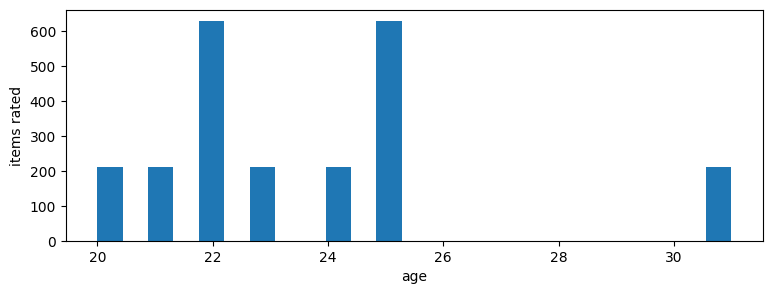

In [366]:
from matplotlib.colors import ListedColormap
inv = lambda dikt: {v:k for k,v in dikt.items()} 

f, a = plt.subplots(figsize=(9,3))

col_ix = np.where(df['trial_type'] == 'actual', 1, 0)
sub_ix = np.array([subject_to_ix[sub] for sub in df.subject_id])

cmap = ListedColormap(('r', 'b'))
hist = a.hist(df['age'], bins='fd')

# a.set_xticks(np.arange(0, 30_000, 2_000))
# a.set(xscale='log')
a.set(xlabel='age', ylabel='items rated')

plt.show()

In [375]:
df.sample(10)[['item', 'response', 'subject_id']]

,item,response,subject_id
1143,vocal detection,3,603af68f8d9a2b7881a2aebe
438,due keywords,-1,5fe932138929f08811367974
663,numerous rhetoric,-2,5964a95d1e40d0000196646c
1399,acute rebellion,1,60e4e2669d7efce16a1d7540
88,Welsh acid,-2,60e4e2669d7efce16a1d7540
608,nuclear weapons,3,5fe932138929f08811367974
542,optional approval,2,5fe932138929f08811367974
2260,direct beginning,-1,5ea10b955d9b25000c302fc5
1396,literary access,1,60e4e2669d7efce16a1d7540
363,confident lung,-3,5f19dc86afa07c0894f60578
